## Introduction

This notebook explores migration patterns of purple martins using the **GeoPandas** library.
These birds typically spend the summer breeding season in the eastern United States, and then migrate to South America for the winter.

### 1 - Import Packages

In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'

### 2 - Load Birds Data & Exploratory Analysis

In [2]:
os.chdir(r'C:\Users\LPeve\Dropbox\archive')  #Set directory
birds_df = pd.read_csv('purple_martin.csv')  #Read birds data
birds_df.head()

,timestamp,location-long,location-lat,tag-local-identifier
0,2014-08-15 05:56:00,-88.146014,17.513049,30448
1,2014-09-01 05:59:00,-85.243501,13.095782,30448
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448


In [3]:
birds_df['tag-local-identifier'].nunique()  #There are 11 different birds in the dataset.

11

In [4]:
birds_df.shape

(99, 4)

In [5]:
birds_df.isnull().sum() #Check for NaN values

timestamp               0
location-long           0
location-lat            0
tag-local-identifier    0
dtype: int64

### 3 - Create GeoDataFrame

In [6]:
birds = gpd.GeoDataFrame(birds_df,
                         crs = 'EPSG:4326', 
                         geometry = gpd.points_from_xy(birds_df['location-long'], birds_df['location-lat']))
birds.head()

,timestamp,location-long,location-lat,tag-local-identifier,geometry
0,2014-08-15 05:56:00,-88.146014,17.513049,30448,POINT (-88.14601 17.51305)
1,2014-09-01 05:59:00,-85.243501,13.095782,30448,POINT (-85.24350 13.09578)
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448,POINT (-62.90609 -7.85244)
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448,POINT (-61.77683 -11.72390)
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448,POINT (-61.24154 -11.61224)


### 4 - Load world countries polygons dataset

This dataset is included in the GeoPandas library.

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #Load Dataset
ct_list = ['North America', 'South America']
americas = world.query('continent in @ct_list')  #Query for countries in America 
americas.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."


### 5 - Plotting

In [8]:
americas.crs == birds.crs   #Check same CRS

True

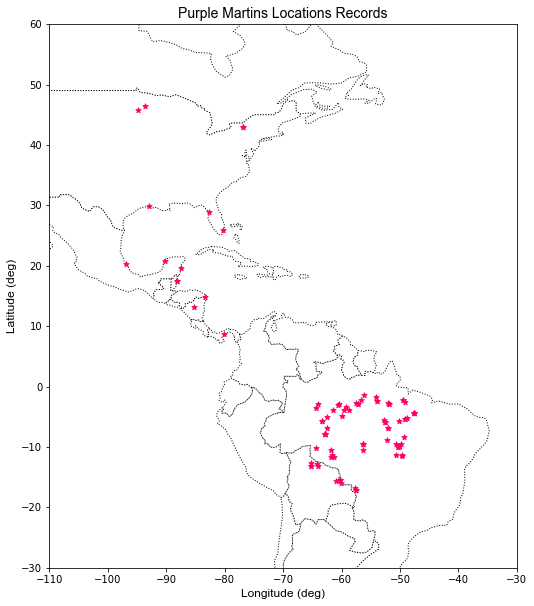

In [9]:
#Plot Base Map
ax = americas.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot Birds Tracked Locations
birds.plot(ax=ax, marker = '*', markersize=30, color= '#FF0066')

#Graph Labels
ax.set_title('Purple Martins Locations Records',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 

#Zoom in
ax.set_xlim([-110, -30])
ax.set_ylim([-30, 60]);
#plt.savefig('fig1.png',facecolor='w')

### 6 - Track Birds Journey

In [10]:
birds.head(1)

,timestamp,location-long,location-lat,tag-local-identifier,geometry
0,2014-08-15 05:56:00,-88.146014,17.513049,30448,POINT (-88.14601 17.51305)


#### Birds Path Point

In [11]:
grp_list = birds.groupby("tag-local-identifier")['geometry'].apply(list) # #Grupby using Tag-Identifier and get a List of POINTS
grp_list_LS = grp_list.apply(lambda x: LineString(x)).reset_index()    #Convert POINTS to LineSTRING and get a DF
path_gdf = gpd.GeoDataFrame(grp_list_LS, 
                            crs = 'epsg:4326',
                            geometry=grp_list_LS['geometry'])
path_gdf.head(2)

,tag-local-identifier,geometry
0,30048,"LINESTRING (-90.12992 20.73242, -56.29394 -10...."
1,30054,"LINESTRING (-93.60861 46.50563, -63.28897 -5.7..."


--------------------------

#### Birds Start & End Points

In [12]:
#Groupby Tag - Make a list for each Bird - Get first point for each bird
start = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[0]) 
start_df = start.reset_index() 
start_gdf = gpd.GeoDataFrame(start_df, 
                            crs = 'epsg:4326',
                            geometry=start_df['geometry'])

end = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[-1]) 
end_df = end.reset_index() 
end_gdf = gpd.GeoDataFrame(end_df, 
                            crs = 'epsg:4326',
                            geometry=end_df['geometry'])

In [13]:
start_gdf.head(2)

,tag-local-identifier,geometry
0,30048,POINT (-90.12992 20.73242)
1,30054,POINT (-93.60861 46.50563)


In [14]:
end_gdf.head(2)

,tag-local-identifier,geometry
0,30048,POINT (-47.53632 -4.43758)
1,30054,POINT (-62.47914 -5.03840)


#### Plotting

Text(0.5, 88.87478354707369, 'Longitude (deg)')

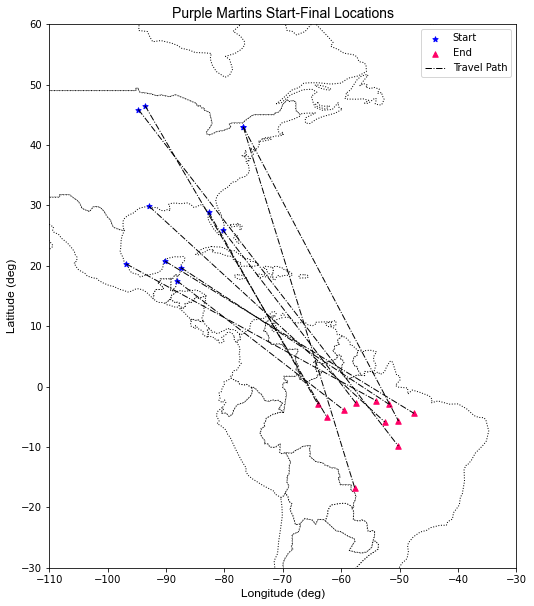

In [15]:
#Plot Base Map
ax = americas.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot Start Points
start_gdf.plot(ax=ax, marker = '*', markersize=30, color= '#0000FF', label = 'Start')

#Plot End Points
end_gdf.plot(ax=ax, marker = '^', markersize=30, color= '#FF0066', label  = 'End')

#Loop to show get start-end points as LineStrings
ll = []
for item in range(len(start_gdf)):
    ll.append(LineString( (start_gdf['geometry'].loc[item] , 
                           end_gdf['geometry'].loc[item])
                        ))

travel_gdf = gpd.GeoSeries(ll,crs = 'epsg:4326')
travel_gdf.plot(color = 'k', ls ='-.' , lw =1 , ax=ax, label  = 'Travel Path')

plt.legend(prop={'size' : 10})

#Zoom in
ax.set_xlim([-110, -30])
ax.set_ylim([-30, 60]);

#Graph Labels
ax.set_title('Purple Martins Start-Final Locations',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 
#plt.savefig('fig2.png',facecolor='w')

### 7 - Protected Areas in South America

In [16]:
protected_filepath = r"SAPA_Aug2019-shapefile\SAPA_Aug2019-shapefile\SAPA_Aug2019-shapefile-polygons.shp"
protected_areas = gpd.read_file(protected_filepath)
protected_areas.head(3)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
0,14067.0,14067,1,Het Spaans Lagoen,Het Spaans Lagoen,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,Not Reported,...,Not Reported,Not Reported,Not Reported,Management plan is not implemented and not ava...,State Verified,1856,Not Reported,NLD,ABW,"POLYGON ((-69.97523 12.47379, -69.97523 12.473..."
1,14003.0,14003,1,Bubali Pond Bird Sanctuary,Bubali Pond Bird Sanctuary,Bird Sanctuary,Bird Sanctuary,National,Not Reported,Not Applicable,...,Not Reported,Not Reported,Not Reported,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"POLYGON ((-70.04734 12.56329, -70.04615 12.563..."
2,555624439.0,555624439,1,Arikok National Park,Arikok National Park,National Park,National Park,National,Not Reported,Not Applicable,...,Non-profit organisations,Non-profit organisations,Fundacion Parke Nacional Arikok,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"MULTIPOLYGON (((-69.96302 12.48384, -69.96295 ..."


In [17]:
south_america = americas.query("continent == ['South America']")
south_america.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."


In [18]:
protected_areas['MARINE']

0       1
1       2
2       1
3       0
4       0
       ..
4743    0
4744    0
4745    0
4746    0
4747    0
Name: MARINE, Length: 4748, dtype: object

Text(0.5, 80.45860397393123, 'Longitude (deg)')

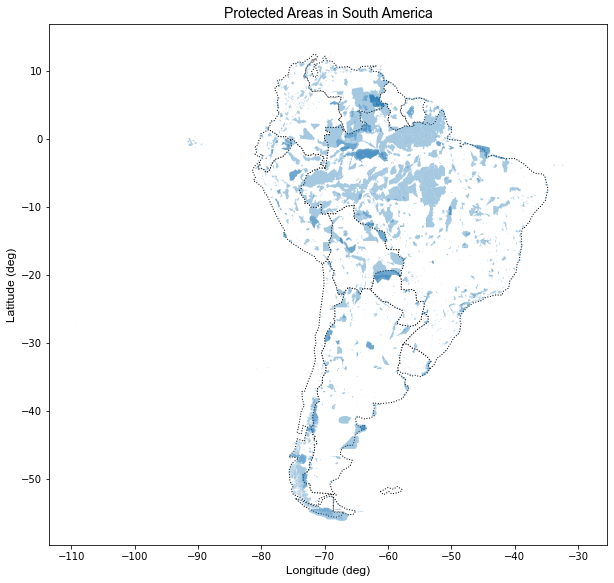

In [19]:
#Plot South America Polygons
ax = south_america.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot South America Protected LAND Areas
land = protected_areas.query("MARINE not in ['2']")     #exclude protected areas that are purely marine areas
land.plot(ax=ax, alpha=0.4, label = 'Protected Areas')

#Graph Labels
ax.set_title('Protected Areas in South America',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 
#plt.savefig('fig3.png',facecolor='w')

#### 7 - What percentage of South America is protected?

In [20]:
protected_areas.rename(columns = {'REP_AREA': 'Total Area',
                                  'REP_M_AREA': 'Total Marine Area'},inplace=True)

#Calcualte the Protected LAND Area (i.e, total - marine)
P_LAND_Area = sum(protected_areas['Total Area']-protected_areas['Total Marine Area'])
print(f"South America has {round(P_LAND_Area,0)} square kilometers of protected areas.")

South America has 5396762.0 square kilometers of protected areas.


In [21]:
#Calculate Total Area of SouthAmerica
s1 = south_america['geometry'].to_crs(epsg=3035) #Geographic System to Projection - Lambert Azimuthal Equal Area
S_America_total_Area = sum(s1.area) / 10**6      # sum(s1.area) is in units of square meters

In [22]:
#Get Percentage
land_pct = round(P_LAND_Area/S_America_total_Area*100, 2)
print(f"South America has {land_pct}% of protected areas.")

South America has 30.39% of protected areas.


### 8 - Where are the birds in South America?

#### All Points

Text(0.5, 95.1913025149132, 'Longitude (deg)')

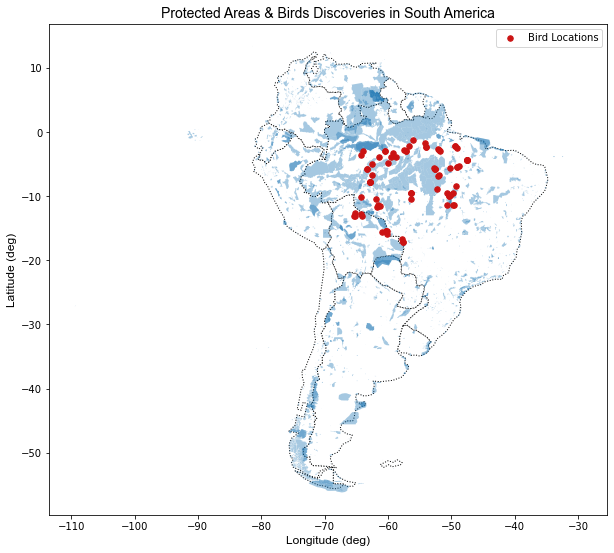

In [23]:
ax = south_america.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot South America LAND Protected Areas
land.plot(ax=ax, alpha=0.4, label = 'Protected Areas')

#Plot Final Location of Birds
birds[birds.geometry.y < 0].plot(ax=ax, marker = 'o', markersize=30, color= '#CB1313', label  = 'Bird Locations')

plt.legend(prop={'size' : 10})

#Graph Labels
ax.set_title('Protected Areas & Birds Discoveries in South America',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 
#plt.savefig('fig3.png',facecolor='w')

#### Distinguish Points within Protected Area

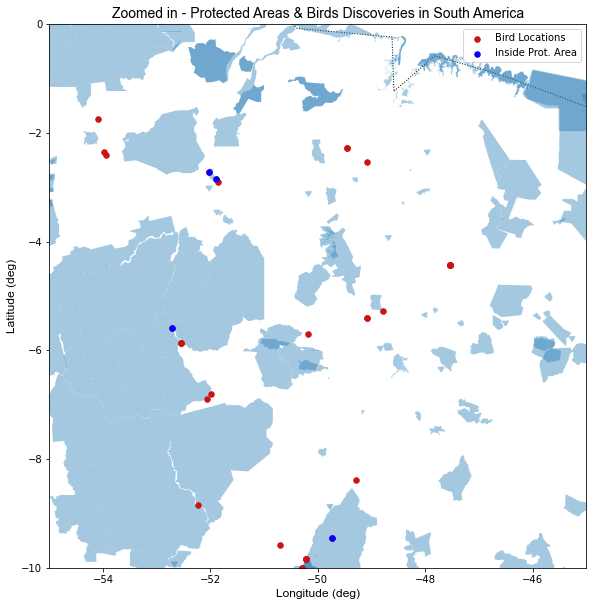

In [24]:
birds_SA = birds[birds['geometry'].y < 0] #Birds in South America

#Get the index of the locations inside Protected Areas
ll = []
for item in birds_SA.index:
    if any(protected_areas['geometry'].contains(birds_SA.loc[item,'geometry'])): #Contains will return a boolean for each row in protected_areas
        ll.append(item)
        
ax = south_america.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot South America LAND Protected Areas
land.plot(ax=ax, alpha=0.4, label = 'Protected Areas')

#Plot Final Location of Birds
birds[birds.geometry.y < 0].plot(ax=ax, marker = 'o', markersize=30, color= '#CB1313', label  = 'Bird Locations')
birds.loc[ll].plot(ax=ax, marker = 'o', markersize=30, color= 'b', label  = 'Inside Prot. Area')

plt.legend(prop={'size' : 10})

#Graph Labels
ax.set_title('Zoomed in - Protected Areas & Birds Discoveries in South America',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 

ax.set_xlim([-55, -45])
ax.set_ylim([-10, 0]);
plt.savefig('fig3.png',facecolor='w',dpi=600)

### 9 - Calculate Travel Distance & Plot Longest and Shortest

In [25]:
ll = []
for item in range(len(start_gdf)):
    ll.append(LineString( (start_gdf['geometry'].loc[item] , 
                           end_gdf['geometry'].loc[item])
                        ))
travel_gdf = gpd.GeoSeries(ll,crs = 'epsg:4326')

In [26]:
#Set Projection to WGS 84 / World Equidistant Cylindrical
travel_gdf_LI = travel_gdf.to_crs(epsg=4087)

In [27]:
#Calculate Length in kilometers since CRS is in meters
distances = travel_gdf_LI.length / 1000
distances.describe()

count      11.000000
mean     5597.235097
std      1307.182354
min      3982.457379
25%      4402.522899
50%      5507.495821
75%      6439.729344
max      7939.482093
dtype: float64

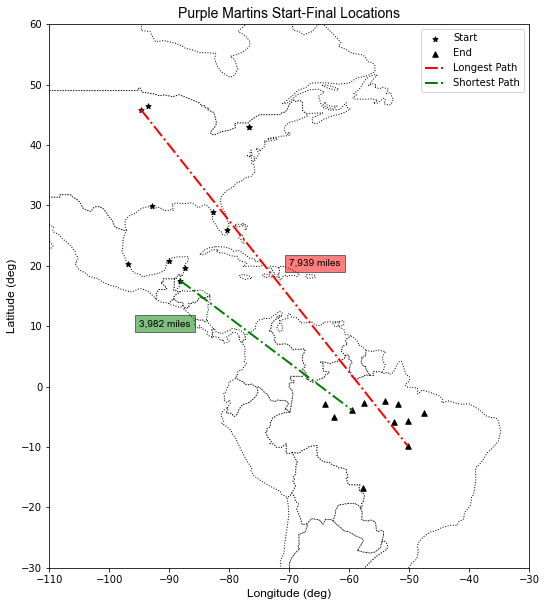

In [28]:
longest = gpd.GeoSeries(travel_gdf.loc[distances.idxmax()],crs = 'epsg:4326')
shortest = gpd.GeoSeries(travel_gdf.loc[distances.idxmin()],crs = 'epsg:4326')

#Plot Base Map
ax = americas.plot(figsize=(10,10), color='white', linestyle=':', edgecolor='black')

#Plot Start Points
start_gdf.plot(ax=ax, marker = '*', markersize=30, color= 'k', label = 'Start')

#Plot End Points
end_gdf.plot(ax=ax, marker = '^', markersize=30, color= 'k', label  = 'End')

#Plot Longest
longest.plot(color = 'r', ls ='-.' , lw =2 , ax=ax, label  = 'Longest Path')

#Plot Longest
shortest.plot(color = 'g', ls ='-.' , lw =2 , ax=ax, label  = 'Shortest Path')

plt.legend(prop={'size' : 10})

#Zoom in
ax.set_xlim([-110, -30])
ax.set_ylim([-30, 60]);

#Graph Labels
ax.set_title('Purple Martins Start-Final Locations',font='Arial',fontsize=14) 
ax.set_ylabel('Latitude (deg)',font='Arial',fontsize=12) 
ax.set_xlabel('Longitude (deg)',font='Arial',fontsize=12) 

#Add Labels
ax.text(-70,20, '7,939 miles' , fontsize=20,font = 'Arial',bbox=dict(facecolor='red', alpha=0.5))
ax.text(-95,10, '3,982 miles' , fontsize=20,font = 'Arial',bbox=dict(facecolor='green', alpha=0.5))
plt.savefig('fig2.png',facecolor='w')